In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

/Users/duqiming2004/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Toy Example (dim = 1)
* $X \sim \mathcal{N}(0,1)$ r.v that we could simulate
* $S:\mathbb{R} \to \mathbb{R}$ score function / blackbox i.e. we could simulate $S(X)$, but we don't know the form of $S$. here we take $S(X) = |X| $
* Goal : estimate $p = \mathbb{P}(S(X)>q) < 10^{-6}$ ( q = 5 rare event)

In [2]:
from numba import autojit
@autojit
def S(X):
    '''score function which is a black box'''
    return np.abs(X)


### remark
(cf. Sequential Monte Carlo for Rare Event Estimation(F.Cérou, P.Del Moral, T.Furon, A.Guyader)):
http://www.lsta.lab.upmc.fr/modules/resources/download/labsta/Pages/Guyader/cdfg.pdf

## Fixed-levels Algorithm:

#### Parameters:

N: the number of particles

$\{L_0,...,L_n\}$: the sequence of levels, where $L_0 = -\infty$

#### Initialization

Draw an i.i.d. N-sample $(X_0^j)_{1\leq j\leq N}$ of law $\mu$

#### Iterations

*for k = 0 to n-1:*

Let $I_k  = \{j : X_k^j \in A_{k+1}\}$ where $A_{k+1} = \{x \in \mathbb{R}^d : S(x) > L_k\}$

Let $\hat p_k = \frac{\#|T_k|}{N}$

if $j \in I_k$, let $\tilde X_{k+1}^j = X_k^j$

if $j \notin I_k$, let $\tilde X_{k+1}^j$ be a copy of $X_k^l$ where $l$ is chosen randomly in $I_k$ with uniform
probabilities.



############# *Question* ################


The multinominal method of choosing $\tilde X_{k+1}^j$ becomes expensive when the particle number increase. At the same time, there would be a problem when $I_k$ is empty, which would be possible when the level becomes large (i.e the $A_{k+1}$ is rare), a possible solution is to regenerate an $X_{new} \sim \mathcal{L}( X | S(X)>L_{k+1})$ with rejection sampling(this could ensure that the $I_k$ is not empty). However, this method end up with an analogue version of classic monte-carlo procedure.



#### Solution:

We will use a trick to simplify the multinominal: we get new copie of $\tilde X_{k+1}^j$ by doing the permutation to $I_k$, i.e. we will use a deterministic method.

This procedure is far more effecient than the generation mentioned above. However, to ensure that $I_k$ is not empty for every level k, we should draw a big number of particles. 
########################################


*for j from 1 to N:*

Draw a new particle $\hat X_{k+1}^j \sim K(\tilde X_{k+1}^j,\cdot )$

if $\hat X_{k+1}^j \in A_{k+1}$, let $X_{k+1}^j = \hat X_{k+1}^j$, else let $X_{k+1}^j = \tilde X_{k+1}^j$

(that is to say, with the condition that $X \in A_{k+1}$, we will only accept the transition in $A_{k+1}$ )

#### Output

Estimate the proba of the rare events by $\hat p = \prod_{k = 0}^{n - 1} \hat p_k $

In [254]:
from scipy.stats import norm

# sequence of levels

q_test = 4
p = (1-norm.cdf(q_test))*2

###idealized situation
p_0 = 0.5 #success rate
n_0 = int(np.log(p)/np.log(p_0))
r = p/(p_0**n_0)

print "p_0 = ", p_0, '\t n_0 =',n_0,"\t r = ",r

L = [-np.Inf]
for k in range(1,n_0+1,1):
    L = np.append(L, norm.ppf(1 - p_0**k/2))
L_ideal = np.append(L, q_test)
num_lev = len(L_ideal)

##var_relative
sigma_theoric = np.sqrt(n_0*(1-p_0)/p_0 + (1-r)/r)
print "sequence of levels: ", L_ideal
print "num_lev: ",num_lev
print "level interested, L = ",q_test
# real value of p
print "real value of p:" ,p
print "theoric relative variance: ", sigma_theoric**2

p_0 =  0.5 	 n_0 = 13 	 r =  0.518901626194
sequence of levels:  [       -inf  0.67448975  1.15034938  1.53412054  1.86273187  2.15387469
  2.41755902  2.66006747  2.88563491  3.09726908  3.29719335  3.4871041
  3.66832929  3.84193069  4.        ]
num_lev:  15
level interested, L =  4
real value of p: 6.33424836662e-05
theoric relative variance:  13.9271475546


In [204]:
# print (1-norm.cdf(3.84193069))*2
# 0.5**13

In [232]:
#tuning parameter 
sigma_1 = 1
#std_tuning = np.sqrt(sigma_1**2)/(1+sigma_1**2)
std_tuning = np.float(sigma_1**2)/(1+sigma_1**2)
c = np.sqrt(1+sigma_1**2)
L = L_ideal


print "std_tuning: ",std_tuning
print "levels: ", L

# ###Estimation of p

N = 10000 # number of samples
X= np.random.normal(0,1,N) 
p_hat = []

for k in range(num_lev-1):
    
    print "k = ", k  
###### construction of I_k 

    I = [X[j] for j in range(N) if S(X[j])>L[k+1]]
    l = len(I)
    p_hat = np.append(p_hat, l/np.float(N))
    #print "estimation of p_k" ,p_hat[k]
######


    X_tilde = np.zeros(N)
    X_tilde[0:l] = I
    I = np.random.permutation(I)
    for j in range(l,N,1):
        X_tilde[j] = I[j%l]
    
    for j in range(N):            
        X_iter = np.random.normal(X_tilde[j]/c,std_tuning,1)
        if S(X_iter)>L[k+1]:
            X[j] = X_iter
        else:
            X[j] = X_tilde[j]

    if np.sum(S(X[j])<=L[k+1])==0:
        print "yes"
        
            
    #print "size of I_k: ", l
    #print"\t"
    
    

var_rel = np.sqrt(N) * (p - np.prod(p_hat))/p
print "real value of p:" ,p
print "estimation of p: ", np.prod(p_hat)
print "relative variation: ", var_rel
print "N: ",N






std_tuning:  0.5
levels:  [       -inf  0.67448975  1.15034938  1.53412054  1.86273187  2.15387469
  2.41755902  2.66006747  2.88563491  3.09726908  3.29719335  3.4871041
  3.66832929  3.84193069  4.00877259  4.16956932  4.32491904  4.47532842
  4.621231    4.76300103  4.90096421  5.        ]
k =  0
yes
k =  1
yes
k =  2
yes
k =  3
yes
k =  4
yes
k =  5
yes
k =  6
yes
k =  7
yes
k =  8
yes
k =  9
yes
k =  10
yes
k =  11
yes
k =  12
yes
k =  13
yes
k =  14
yes
k =  15
yes
k =  16
yes
k =  17
yes
k =  18
yes
k =  19
yes
k =  20
yes
real value of p: 5.73303143847e-07
estimation of p:  2.32258359858e-13
relative variation:  99.9999594877
N:  10000


In [230]:
a = [213,13,55,12,33,44]
np.random.permutation(a)

array([ 12, 213,  55,  33,  13,  44])

### remark
(cf. Sequential Monte Carlo for Rare Event Estimation(F.Cérou, P.Del Moral, T.Furon, A.Guyader)):
http://www.lsta.lab.upmc.fr/modules/resources/download/labsta/Pages/Guyader/cdfg.pdf


## Adaptive Multilevel Splitting    

#### parameter:

$N$:  the number of particles

$N_0$: the number of succeeding particles

$p_0 = \frac{N_0}{N}$ : the success rate

$L$: the level we want to estimate

#### Initialization

Draw an i.i.d. N-sample $(X_0^j)_{1\leq j\leq N}$ of law $\mu$

Compute the $\hat L_1$, the $(1-p_0)$ quantile of $(S(X_0^j))_{1\leq j \leq N}$

k = 1, index of level

#### Iterations

while $\hat L_k < L$ do:

Starting from an i.i.d. $p_0 N$-sample with law $\mathcal{L}(X|S(X) > L_k)$,
draw an i.i.d. $N$-sample $(X_k^j)_{1 \leq j \leq N}$ with the same law.

################# *remark* ##################

Here we use the same trick as in fixed-level splitting, i.e. conducting a permutation to draw an an i.i.d. $(1-p_0)N$-sample $(X_k^j)_{1 \leq j \leq N}$ with the same law.

############################################

Compute the $\hat L_{k+1}$, the $(1-p_0)$ quantile of $(X_k^j)_{1 \leq j \leq N}$

k = k + 1

end while

Calculate $N_L = \#\{j : S(X_{k-1}^j) \geq L\}$

#### Output

Estimate the probability of the rare event by $\hat p = \frac{N_L}{N}p_0^{k-1}$.

#### remark

* The adaptive version is biased 

$$bias \sim O(\frac1N)$$

* The bias is non-negative, so the estimation is always a little bit overvalued





In [131]:
q_test = 4
from scipy.stats import norm
p = (1-norm.cdf(q_test))*2
print "real value of p:" ,p




p_0 = 0.75 # prescribed success rate
N = 50000 #size of sample

# calculate the empirical quantile of X
#@autojit
def L_empirical(X,alpha, N):
    
    #N = len(X)
    #return np.percentile(np.sort(S(X)),(1-alpha)*100.,interpolation="lower")
    return np.sort(S(X))[np.int((1-alpha)*N)]

###Estimation of p

## To ensure that L_k != empty
X = np.random.normal(0,1,N)
while(np.sum((S(X)>q_test)) == 0):
    X = np.random.normal(0,1,N)

L = np.array([-np.Inf,L_empirical(X ,p_0 ,N )])
k = 1

while(L[k]<q_test):
    print "\t"
    print "k = ",k
    print 'current level: ', L[k]
    I = []
    
 

    for i in range(N):
        if S(X[i])>L[k]:
            I = np.append(I, X[i])
    l = len(I)
    print "size of I_k: ", l
       
    X[0:l] = I
    
########## permutation trick to replace multinominal distribution
    I = np.random.permutation(I)
    for i in range(l,N,1):
        X[i] = I[i%l]
    
            
# rejection sampling = naive m.c.           
#             while(S(X_tilde)<=L[k]):
#                 X_tilde = np.random.normal(0,1,1)
            

#            X_new = np.append(X_new, X_tilde)         
    
    L = np.append(L, L_empirical(X,p_0 ,N))
    k += 1

print "final k = ",k
    
N_L = np.sum((S(X)>q_test))
p_hat = N_L/float(N)*p_0**(k-1)
L_adapted = L[0:-1]
L_adapted = np.append(L_adapted, q_test)

print "real value of p:" ,p
print "estimation of p: ", p_hat
print "relative variation: ",np.abs((p - p_hat))/p*np.sqrt(N)
print "N: ",N



real value of p: 6.33424836662e-05
	
k =  1
current level:  0.315471436092
size of I_k:  37499
	
k =  2
current level:  0.574728455419
size of I_k:  37498
	
k =  3
current level:  0.802304693732
size of I_k:  37497
	
k =  4
current level:  1.00559402152
size of I_k:  37499
	
k =  5
current level:  1.18455272393
size of I_k:  37498
	
k =  6
current level:  1.3490944986
size of I_k:  37497
	
k =  7
current level:  1.5055203624
size of I_k:  37496
	
k =  8
current level:  1.64866643104
size of I_k:  37497
	
k =  9
current level:  1.79234822736
size of I_k:  37498
	
k =  10
current level:  1.92061628117
size of I_k:  37496
	
k =  11
current level:  2.04259416964
size of I_k:  37479
	
k =  12
current level:  2.15532947254
size of I_k:  37499
	
k =  13
current level:  2.24712666853
size of I_k:  37432
	
k =  14
current level:  2.3570768134
size of I_k:  37486
	
k =  15
current level:  2.47149501432
size of I_k:  37415
	
k =  16
current level:  2.56894519819
size of I_k:  37497
	
k =  17
curr

In [ ]:
L_adapted = L[0:-1]
L_adapted = np.append(L_adapted,q_test)
print "levels (adapted version): ", L_adapted

## Fluctuation Analysis

In this section we will do some analysis of the comportment of $\frac{\hat p - p}{p}$. In the idealized situation, by the thm of CTL, it converges to a normal law and we are interested in estimating the variance of this normal distribution.

In [ ]:
def fixed_sim(N,sigma_1 = 1, L = L_ideal):
    #tuning parameter 
    
    std_tuning = np.sqrt(sigma_1**2)/(1+sigma_1**2)
    c = np.sqrt(1+sigma_1**2)

    #print "std_tuning: ",std_tuning
    #print "levels: ", L


    ###Estimation of p

    X = np.random.normal(0,1,N)
    while(np.sum((S(X)>q_test)) == 0):
        X = np.random.normal(0,1,N)

 
    p_hat = []
    num_lev = len(L)
    for k in range(num_lev-1):
        I = []
        X_tilde = np.zeros(N)
        #print "k = ", k 


    ###### construction of I_k 
        for j in range(N):
            if S(X[j])>=L[k+1]:
                I = np.append(I,X[j])  
        l = len(I)
        p_hat = np.append(p_hat, l/float(N))
        #print "estimation of p_k" ,p_hat[k]
    ######

        X_tilde[0:l] = I
        I = np.random.permutation(I)
        for i in range(l,N,1):
            X_tilde[i] = I[i%l]
        #the shaker
        for j in range(N):            
            X_iter = np.random.normal(X_tilde[j]/c,std_tuning,1)
            if S(X_iter)>L[k+1]:
                X[j] = X_iter

        #print "size of I_k: ", l
        #print"\t"



    var_rel = (p - np.prod(p_hat))/p*np.sqrt(N)
    #print "real value of p:" ,p
    #print "estimation of p: ", np.prod(p_hat)
    #print "relative variation: ", var_rel
    #print "N: ",N
    return np.prod(p_hat),var_rel




In [233]:
def adapted_sim(N, q_test = 4, p_0 = 0.75):

    p = (1-norm.cdf(q_test))*2
#print "real value of p:" ,p




     # prescribed success rate


    # calculate the empirical quantile of X
    #@autojit

    ###Estimation of p

    ## To ensure that L_k != empty
    X = np.random.normal(0,1,N)
    while(np.sum((S(X)>q_test)) == 0):
        X = np.random.normal(0,1,N)

    L = np.array([-np.Inf,L_empirical(X, p_0, N)])
    k = 1

    while(L[k]<q_test):
        #print "\t"
        #print "k = ",k
        #print 'current level: ', L[k]
        I = []



        for i in range(N):
            if S(X[i])>L[k]:
                I = np.append(I, X[i])
        l = len(I)
        #print "size of I_k: ", l

        X[0:l] = I

    ########## permutation trick to replace multinominal distribution
        I = np.random.permutation(I)
        for i in range(l,N,1):
            X[i] = I[i%l]


    # rejection sampling = naive m.c.           
    #             while(S(X_tilde)<=L[k]):
    #                 X_tilde = np.random.normal(0,1,1)


    #            X_new = np.append(X_new, X_tilde)         

        L = np.append(L, L_empirical(X, p_0, N))
        k += 1

    #print "final k = ",k

    N_L = np.sum((S(X)>q_test))
    p_hat = N_L/float(N)*p_0**(k-1)
    L_adapted = L[0:-1]
    L_adapted = np.append(L_adapted, q_test)
    
    return p_hat, np.sqrt(N) * (p-p_hat)/p

#     print "real value of p:" ,p
#     print "estimation of p: ", p_hat
#     print "relative variation: ",np.abs((p - p_hat))/p*np.sqrt(N)
#     print "N: ",N




In [ ]:
# n_sim = 100
# #N = 100, 1000, 10000, 100000
# sim_N =[[] for i in range(4)]
# for n in range(4):
#     for i in range(n_sim):
#         sim_N[n] = fixed_sim(N = 10*10**n)

In [257]:
#from numba import autojit, prange
n_sim = 1000
sim_5000 = [[] for i in range(n_sim)]
#@autojit
def parallel_sim():
    for i in range(n_sim):
        sim_5000[i] = adapted_sim(1000,2)
parallel_sim ()    
sim_5000

[(0.056313514709472656, -7.5152314628323404),
 (0.037082449436187742, 5.8503982911999204),
 (0.042235136032104492, 2.2692705532966926),
 (0.045107125282287601, 0.27323214200636758),
 (0.046571276664733888, -0.74435606767105034),
 (0.046683903694152831, -0.82263208380008135),
 (0.039996673822402955, 3.8250063738612083),
 (0.037040214300155638, 5.8797517972483071),
 (0.042854584693908689, 1.8387524645870172),
 (0.047979114532470703, -1.7228062692839528),
 (0.045219752311706544, 0.19495612587733654),
 (0.053779406547546385, -5.7540210999291137),
 (0.046909157752990718, -0.97918411605814337),
 (0.05361046600341797, -5.6366070757355669),
 (0.061118934631347654, -10.855008151004384),
 (0.049161698341369631, -2.5447044386387931),
 (0.04101031708717346, 3.1205222286999197),
 (0.048880130767822265, -2.3490143983162106),
 (0.04696547126770019, -1.0183221241226588),
 (0.054849363327026363, -6.4976432531549184),
 (0.039489852190017702, 4.1772484464418529),
 (0.056313514709472656, -7.51523146283234

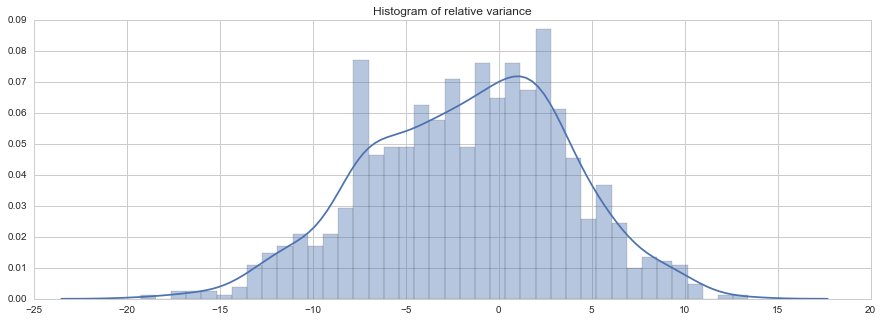

In [270]:
plt.figure(figsize = [15,5])
sns.distplot(np.array(sim_5000)[:,1],bins = 40)
plt.title('Histogram of relative variance')


In [266]:
np.mean(np.array(sim_5000)[:,1])

-1.6595356023718226